# MPC Spacecraft Rendezvous in LEO

This notebook demonstrates **Model Predictive Control (MPC)** for spacecraft
rendezvous in low Earth orbit. A deputy satellite approaches a chief at the
RTN (Radial-Transverse-Normal) frame origin from a fixed initial offset.

Key features:

- **Prediction model**: Linear Hill-Clohessy-Wiltshire (HCW) equations,
  discretised via the closed-form state transition matrix
- **Truth propagation**: Nonlinear two-body dynamics via astrojax
  `create_orbit_dynamics` with RK4 integration
- **Cost function**: L1 fuel cost (promotes sparse impulsive burns) +
  quadratic terminal penalty for soft docking constraint
- **Receding horizon**: At each step, solve the MPC, apply only the first
  control input, re-observe, and repeat

In [1]:
import cvxpy as cp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401

from astrojax import (
    Epoch,
    R_EARTH,
    mean_motion,
    set_dtype,
    state_koe_to_eci,
    zero_eop,
)
from astrojax.integrators import rk4_step
from astrojax.orbit_dynamics import ForceModelConfig, create_orbit_dynamics
from astrojax.relative_motion import (
    hcw_derivative,
    hcw_stm,
    rotation_rtn_to_eci,
    state_eci_to_rtn,
    state_rtn_to_eci,
)

set_dtype(jnp.float64)

plt.style.use(["science", "ieee"])

## Configuration

All tunable parameters are collected here. The chief orbit is a 500 km
circular LEO with 45° inclination. The deputy starts 1 km along-track
behind the chief with small radial and cross-track offsets.

In [2]:
# --- Reproducibility ---
SEED = None                      # Master RNG seed (set None for random each run)
rng = np.random.default_rng(SEED)

# --- Chief orbit ---
SMA = R_EARTH + 500e3          # Semi-major axis [m]
ECC = 0.001                     # Eccentricity (near-circular)
INC = 45.0                      # Inclination [deg]
RAAN = 30.0                     # RAAN [deg]
AOP = 60.0                      # Argument of perigee [deg]
MA = 0.0                        # Mean anomaly [deg]

# --- Deputy initial offset in RTN [m, m/s] ---
# Sampled uniformly from the box [lo, hi] for each RTN axis
RTN_BOX = {
    "R": (-500.0, 500.0),       # Radial [m]
    "T": (-2000.0, -500.0),     # Along-track [m]
    "N": (-300.0, 300.0),       # Cross-track [m]
}
rtn_lo = np.array([RTN_BOX["R"][0], RTN_BOX["T"][0], RTN_BOX["N"][0]])
rtn_hi = np.array([RTN_BOX["R"][1], RTN_BOX["T"][1], RTN_BOX["N"][1]])
RTN_OFFSET = np.concatenate([rng.uniform(rtn_lo, rtn_hi), np.zeros(3)])

# --- Simulation ---
DT = 60.0                       # Integration timestep [s]
N_STEPS = 120                   # Number of steps (2 hours)

# --- MPC ---
HORIZON = 20                    # Prediction horizon [steps]
MAX_DV = 0.5                    # Maximum delta-v per axis per step [m/s]
TERMINAL_WEIGHT = 1e4           # Quadratic terminal penalty
FUEL_WEIGHT = 1.0               # L1 fuel penalty

# --- Derived ---
N_MEAN = float(mean_motion(SMA))

print(f"Semi-major axis: {SMA/1e3:.1f} km")
print(f"Mean motion:     {N_MEAN*1e3:.4f} mrad/s")
print(f"Orbital period:  {2*np.pi/N_MEAN/60:.1f} min")
print(f"Simulation:      {N_STEPS*DT/60:.0f} min ({N_STEPS} steps)")
print(f"RTN offset:      {RTN_OFFSET[:3]} m")

Semi-major axis: 6878.1 km
Mean motion:     1.1068 mrad/s
Orbital period:  94.6 min
Simulation:      120 min (120 steps)
RTN offset:      [-191.01720325 -546.96366605   31.72266797] m


## Dynamics Setup

We build the initial ECI states for chief and deputy using astrojax
coordinate transformations, then construct the truth dynamics using
`create_orbit_dynamics` with a two-body force model. RK4 integration
with substeps provides accurate nonlinear propagation.

In [3]:
# Chief OE -> ECI
chief_oe = jnp.array([SMA, ECC, INC, RAAN, AOP, MA])
chief_eci = state_koe_to_eci(chief_oe, use_degrees=True)

# Deputy: chief + RTN offset -> ECI
rtn_offset = jnp.array(RTN_OFFSET)
deputy_eci = state_rtn_to_eci(chief_eci, rtn_offset)

# Verify the RTN state
true_rtn_0 = state_eci_to_rtn(chief_eci, deputy_eci)
print(f"Initial RTN position: {true_rtn_0[:3]} m")
print(f"Initial RTN velocity: {true_rtn_0[3:]} m/s")
print(f"Initial range:        {np.linalg.norm(np.array(true_rtn_0[:3])):.1f} m")

# Build truth dynamics (two-body)
epoch_0 = Epoch(2024, 6, 15, 12, 0, 0)
dynamics = create_orbit_dynamics(zero_eop(), epoch_0, ForceModelConfig.two_body())

# JIT-compile a single propagation step (10 RK4 substeps per DT for accuracy)
n_substeps = 10
sub_dt = DT / n_substeps

@jax.jit
def propagate_one_step(t, state):
    """Propagate a single ECI state forward by DT using RK4 substeps."""
    def body(carry, _):
        t_i, s = carry
        result = rk4_step(dynamics, t_i, s, sub_dt)
        return (t_i + sub_dt, result.state), None
    (t_out, state_out), _ = jax.lax.scan(body, (t, state), None, length=n_substeps)
    return t_out, state_out

# Verify a single zero-control step
t_test = 0.0
chief_test, deputy_test = chief_eci, deputy_eci
_, chief_test = propagate_one_step(t_test, chief_test)
_, deputy_test = propagate_one_step(t_test, deputy_test)
rtn_after = state_eci_to_rtn(chief_test, deputy_test)
print(f"\nAfter 1 zero-control step:")
print(f"  Range: {float(jnp.linalg.norm(rtn_after[:3])):.1f} m")

Initial RTN position: [-191.01720325 -546.96366605   31.72266797] m
Initial RTN velocity: [-1.59094959e-13  2.73558953e-13 -1.68448588e-13] m/s
Initial range:        580.2 m

After 1 zero-control step:
  Range: 580.6 m


## HCW State Transition Matrix

The MPC prediction model uses the **closed-form** Hill-Clohessy-Wiltshire
state transition matrix (Vallado, Sec. 6.8). For a circular chief orbit
with mean motion $n$ and timestep $\Delta t$, the 6x6 STM $\Phi(\Delta t)$
maps the RTN state forward in time analytically.

An impulsive $\Delta\mathbf{v}$ applied at time $\tau_k$ is modelled by
adding it to the velocity components before propagation:

$$\mathbf{x}(t) = \Phi(t, t_0)\,\mathbf{x}_0 + \sum_i \Phi(t, \tau_i)\,B\,\Delta\mathbf{v}_i$$

where $B$ maps a 3-vector $\Delta\mathbf{v}$ into the 6D state (velocity rows only).

In [4]:
# Built-in hcw_stm signature: hcw_stm(t, n) -> 6x6 JAX array
A_d = np.array(hcw_stm(DT, N_MEAN))

# Input matrix: DeltaV in RTN maps to velocity components
B_d = np.zeros((6, 3))
B_d[3:6, :] = np.eye(3)

print("HCW STM (Phi):")
print(np.array2string(A_d, precision=4, suppress_small=True))

# --- Verification: compare STM vs RK4-integrated HCW ---
x0_test = jnp.array([200.0, -1000.0, 100.0, 0.0, 0.0, 0.0])

# STM prediction
x_stm = A_d @ np.array(x0_test)

# RK4 integration (10 substeps for accuracy)
sub_dt_test = DT / 10.0
x_rk4 = x0_test
for _ in range(10):
    x_rk4 = rk4_step(lambda _t, s: hcw_derivative(s, N_MEAN), 0.0, x_rk4, sub_dt_test).state

diff = np.abs(np.array(x_stm) - np.array(x_rk4))
print("\nSTM vs RK4 difference:")
print(f"  Position: {diff[:3]} m")
print(f"  Velocity: {diff[3:]} m/s")
print(f"  Max pos error: {diff[:3].max():.2e} m")

HCW STM (Phi):
[[ 1.0066  0.      0.     59.9559  3.983   0.    ]
 [-0.0003  1.      0.     -3.983  59.8236  0.    ]
 [ 0.      0.      0.9978  0.      0.     59.9559]
 [ 0.0002  0.      0.      0.9978  0.1327  0.    ]
 [-0.      0.      0.     -0.1327  0.9912  0.    ]
 [ 0.      0.     -0.0001  0.      0.      0.9978]]

STM vs RK4 difference:
  Position: [3.93356459e-11 1.28898137e-09 6.55120402e-12] m
  Velocity: [7.13346049e-13 8.69551826e-14 1.18890141e-13] m/s
  Max pos error: 1.29e-09 m


## MPC Formulation

The MPC solves a convex optimisation problem at each step:

$$\min_{\mathbf{u}} \; w_f \sum_{k=0}^{H-1} \|\mathbf{u}_k\|_1 + w_t \|\mathbf{x}_H\|_2^2$$

subject to:
- HCW dynamics: $\mathbf{x}_{k+1} = \Phi\,(\mathbf{x}_k + B\,\mathbf{u}_k)$
- Box constraints: $\|\mathbf{u}_k\|_\infty \leq \Delta v_{\max}$

The impulse $\mathbf{u}_k$ is added to the state at time $t_k$ and then
the combined state is propagated by the STM $\Phi$, matching
$\Phi(t_{k+1}, t_k)(x_k + B\,\Delta v_k)$.

The **L1 fuel cost** promotes sparse control (fewer, larger burns), which
is physically realistic for impulsive thrusters. The **quadratic terminal
penalty** acts as a soft docking constraint — driving the terminal state
toward zero without hard equality constraints that could cause infeasibility.

In [5]:
def solve_mpc(
    x0: np.ndarray,
    A_d: np.ndarray,
    B_d: np.ndarray,
    horizon: int,
    max_dv: float,
    fuel_weight: float,
    terminal_weight: float,
) -> np.ndarray:
    """Solve the MPC optimisation for one step.

    Args:
        x0: Current 6D RTN state [m, m/s].
        A_d: 6x6 HCW state transition matrix.
        B_d: 6x3 control input matrix.
        horizon: Prediction horizon (number of steps).
        max_dv: Maximum delta-v per axis [m/s].
        fuel_weight: Weight on L1 fuel cost.
        terminal_weight: Weight on quadratic terminal penalty.

    Returns:
        First optimal control input [dv_R, dv_T, dv_N] in m/s.
    """
    H = horizon
    x = cp.Variable((H + 1, 6))
    u = cp.Variable((H, 3))

    cost = 0.0
    constraints = [x[0] == x0]

    for k in range(H):
        # Dynamics: apply impulse then propagate via STM
        constraints.append(x[k + 1] == A_d @ (x[k] + B_d @ u[k]))
        # Box constraint on control
        constraints.append(cp.norm_inf(u[k]) <= max_dv)
        # L1 fuel cost
        cost += fuel_weight * cp.norm1(u[k])

    # Quadratic terminal penalty
    cost += terminal_weight * cp.sum_squares(x[H])

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.CLARABEL, verbose=False)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        print(f"  Warning: solver status = {prob.status}")
        return np.zeros(3)

    return np.array(u.value[0])


# Test the MPC with the initial state
x0_np = np.array(true_rtn_0)
u_test = solve_mpc(x0_np, A_d, B_d, HORIZON, MAX_DV, FUEL_WEIGHT, TERMINAL_WEIGHT)
print(f"Test MPC first control: {u_test} m/s")
print(f"Test MPC |u|_1: {np.sum(np.abs(u_test)):.4f} m/s")

Test MPC first control: [-0.13741529  0.5        -0.01120668] m/s
Test MPC |u|_1: 0.6486 m/s


## MPC Simulation Loop

At each timestep we:
1. Compute the relative RTN state from ECI positions
2. Solve the MPC to get the optimal control
3. Apply the first delta-V impulse (RTN -> ECI) to the deputy
4. Propagate both chief and deputy with nonlinear two-body dynamics
5. Record the trajectory and control history

The MPC uses the linear HCW model for prediction, but the actual
propagation is nonlinear two-body dynamics — a model mismatch that
receding horizon control naturally handles through re-planning.

In [6]:
# Storage
rtn_history = np.zeros((N_STEPS + 1, 6))
dv_history = np.zeros((N_STEPS, 3))
rtn_history[0] = np.array(true_rtn_0)

# Reset ECI states for simulation
chief_sim = chief_eci
deputy_sim = deputy_eci
t = 0.0

for k in range(N_STEPS):
    # Current true RTN state
    x_rtn = np.array(state_eci_to_rtn(chief_sim, deputy_sim))

    # Solve MPC
    u_opt = solve_mpc(x_rtn, A_d, B_d, HORIZON, MAX_DV, FUEL_WEIGHT, TERMINAL_WEIGHT)

    # Apply delta-V in RTN -> convert to ECI
    R = rotation_rtn_to_eci(chief_sim)
    dv_eci = R @ jnp.array(u_opt)
    deputy_sim = deputy_sim.at[3:6].add(dv_eci)

    # Propagate both from the same time
    t_k = t
    t, chief_sim = propagate_one_step(t_k, chief_sim)
    _, deputy_sim = propagate_one_step(t_k, deputy_sim)

    rtn_history[k + 1] = np.array(state_eci_to_rtn(chief_sim, deputy_sim))
    dv_history[k] = u_opt

    if (k + 1) % 20 == 0 or k == 0:
        rng_val = np.linalg.norm(rtn_history[k + 1, :3])
        dv_k = np.sum(np.abs(u_opt))
        print(f"Step {k+1:4d}/{N_STEPS}: range = {rng_val:8.1f} m, |dv| = {dv_k:.4f} m/s")

# Summary
total_dv_l1 = np.sum(np.abs(dv_history))
total_dv_l2 = np.sum(np.sqrt(np.sum(dv_history**2, axis=1)))
final_range = np.linalg.norm(rtn_history[-1, :3])
final_vel = np.linalg.norm(rtn_history[-1, 3:])

print("\n--- Summary ---")
print(f"Total delta-v (L1): {total_dv_l1:.4f} m/s")
print(f"Total delta-v (L2): {total_dv_l2:.4f} m/s")
print(f"Final range:        {final_range:.2f} m")
print(f"Final velocity:     {final_vel:.4f} m/s")

Step    1/120: range =    554.2 m, |dv| = 0.6486 m/s
Step   20/120: range =    100.5 m, |dv| = 0.0375 m/s
Step   40/120: range =      6.2 m, |dv| = 0.0000 m/s
Step   60/120: range =      0.0 m, |dv| = 0.0000 m/s
Step   80/120: range =      0.0 m, |dv| = 0.0000 m/s
Step  100/120: range =      0.0 m, |dv| = 0.0000 m/s
Step  120/120: range =      0.0 m, |dv| = 0.0000 m/s

--- Summary ---
Total delta-v (L1): 1.0952 m/s
Total delta-v (L2): 0.9561 m/s
Final range:        0.00 m
Final velocity:     0.0000 m/s


## 3D RTN Trajectory

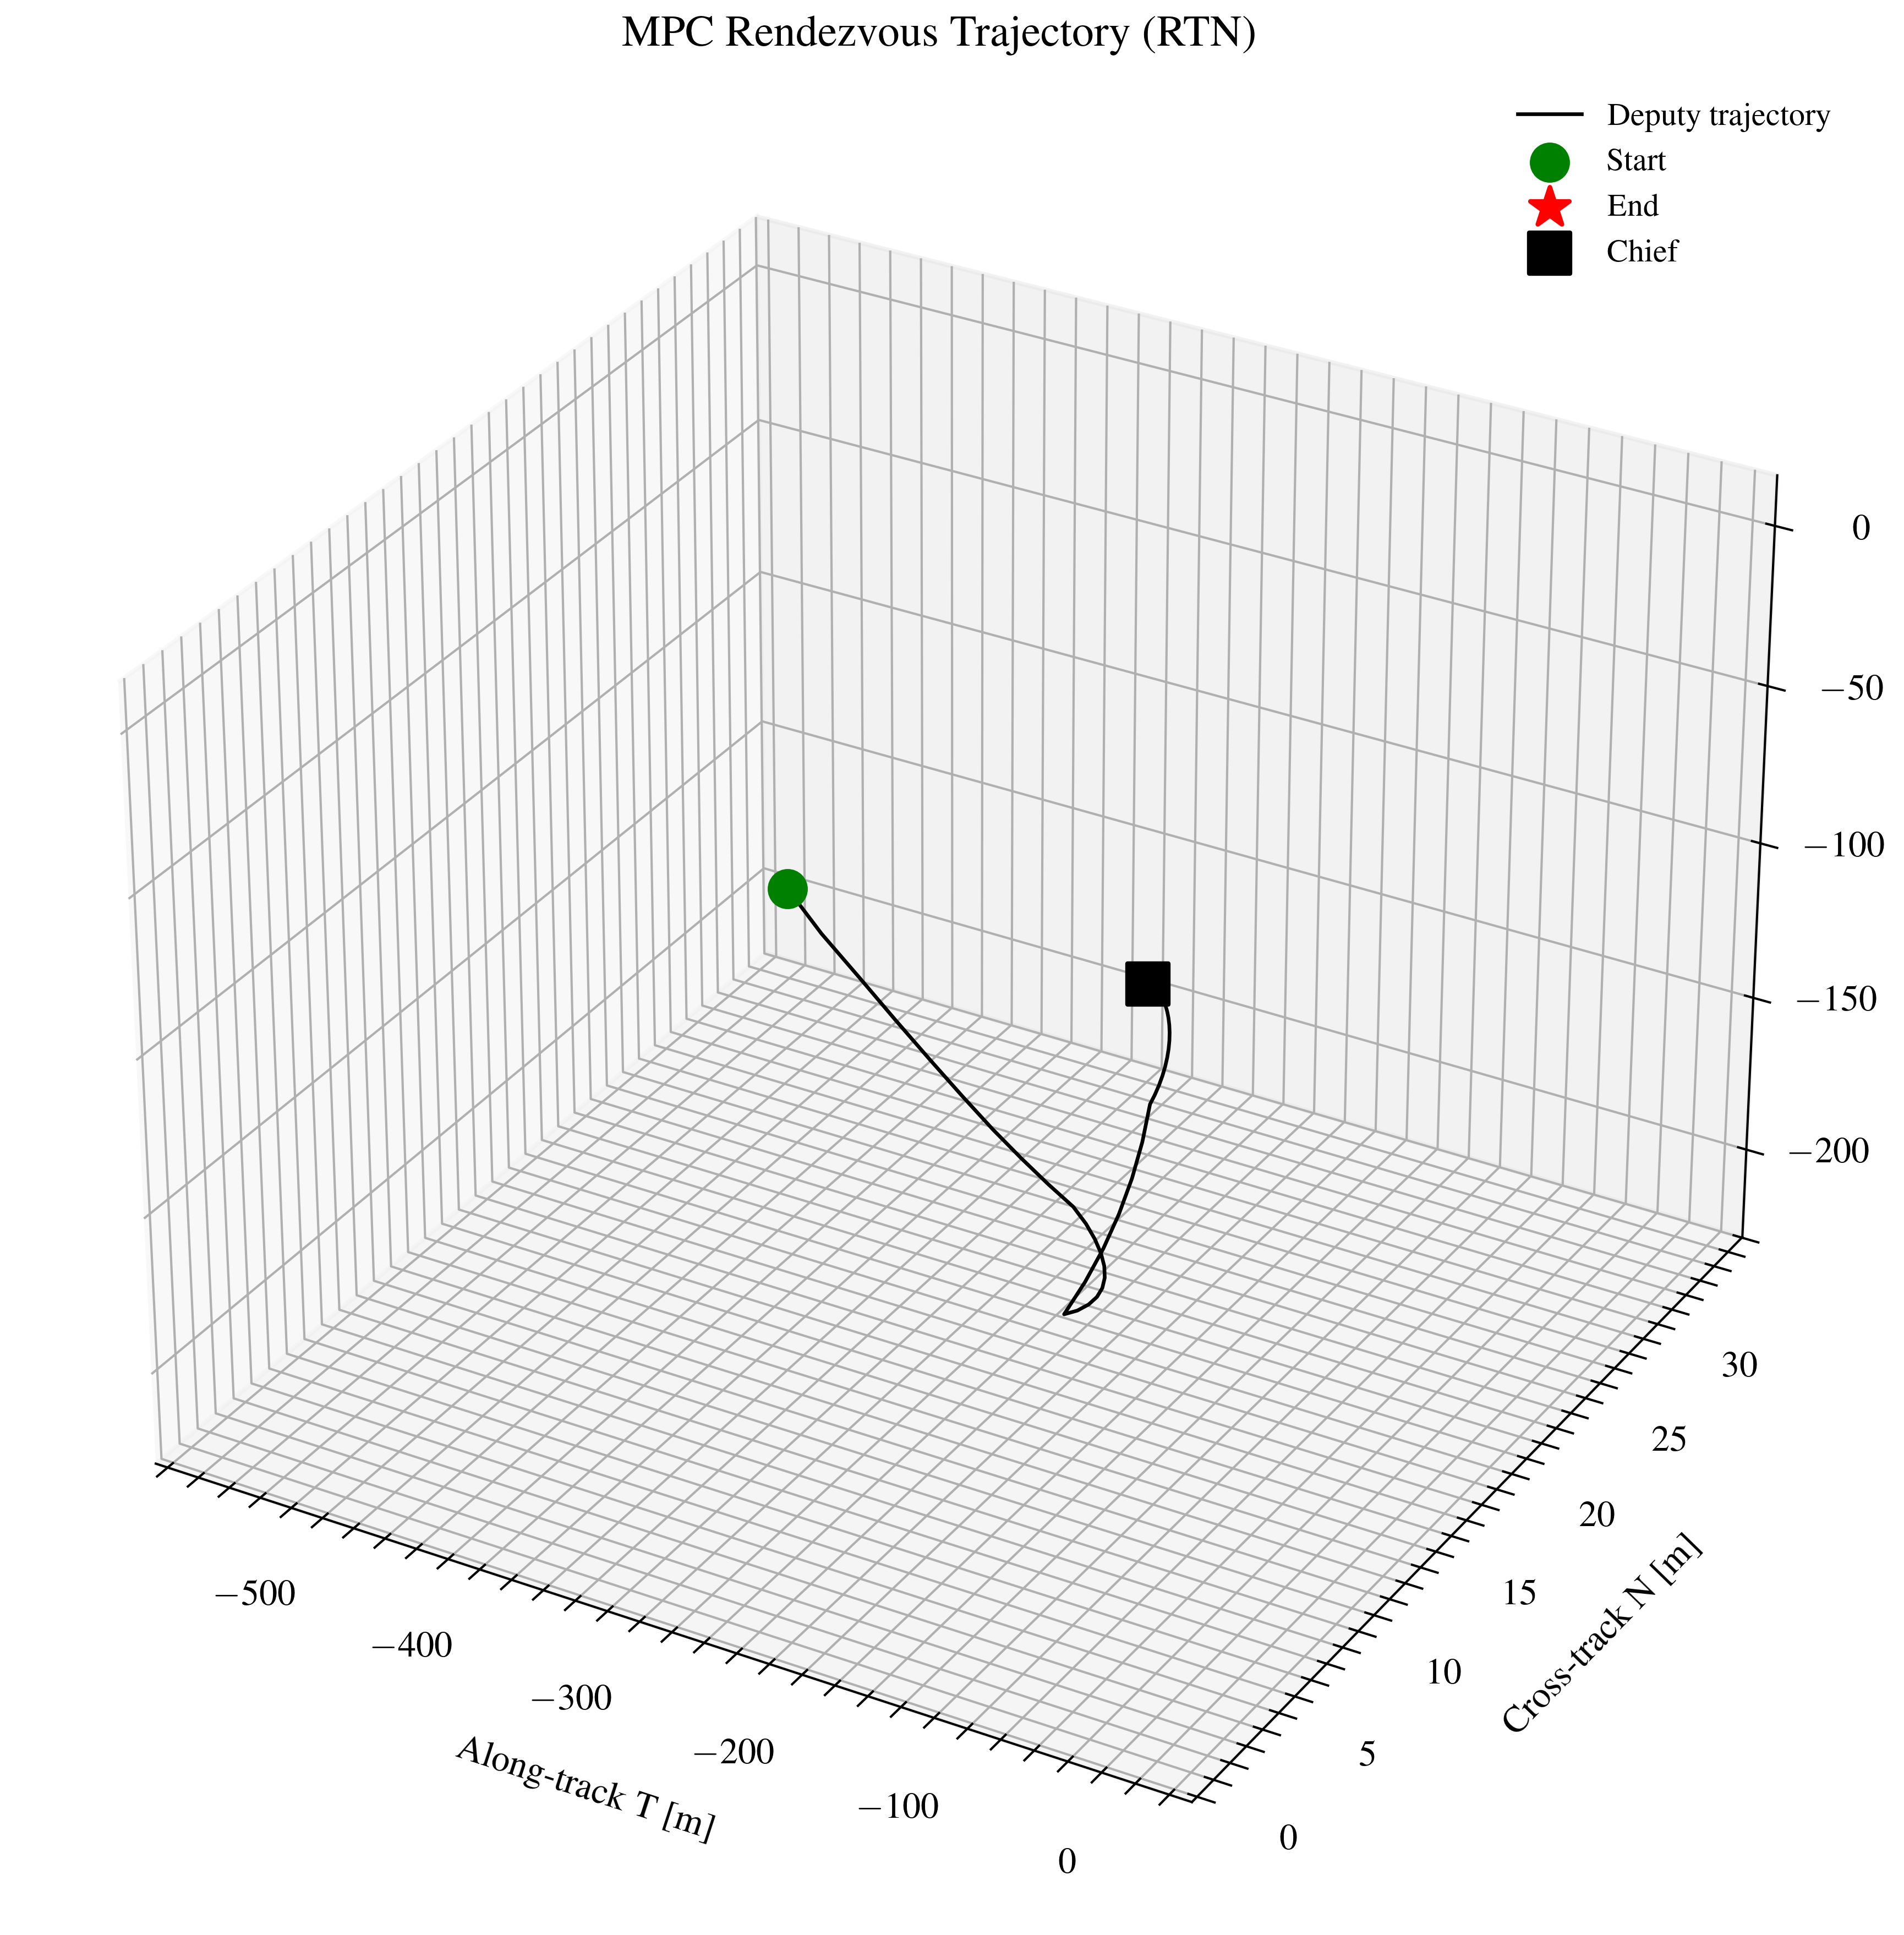

In [7]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

# Axes: X=Along-track, Y=Cross-track, Z=Radial (up)
T = rtn_history[:, 1]  # Along-track
R = rtn_history[:, 0]  # Radial
N = rtn_history[:, 2]  # Cross-track

ax.plot(T, N, R, linewidth=0.8, color="C0", label="Deputy trajectory")
ax.scatter(T[0], N[0], R[0], color="green", s=60, marker="o", zorder=5, label="Start")
ax.scatter(T[-1], N[-1], R[-1], color="red", s=80, marker="*", zorder=5, label="End")
ax.scatter(0, 0, 0, color="black", s=80, marker="s", zorder=5, label="Chief")

ax.set_xlabel("Along-track T [m]")
ax.set_ylabel("Cross-track N [m]")
ax.set_zlabel("Radial R [m]")
ax.set_title("MPC Rendezvous Trajectory (RTN)")
ax.legend(fontsize=7)
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

# Axes: X=Along-track, Y=Cross-track, Z=Radial (up)
T = rtn_history[:, 1]
R = rtn_history[:, 0]
N = rtn_history[:, 2]

ax.plot(T, N, R, linewidth=0.8, color="C0", label="Deputy trajectory")
ax.scatter(T[0], N[0], R[0], color="green", s=60, marker="o", zorder=5, label="Start")
ax.scatter(T[-1], N[-1], R[-1], color="red", s=80, marker="*", zorder=5, label="End")
ax.scatter(0, 0, 0, color="black", s=80, marker="s", zorder=5, label="Chief")

# Thrust vectors at each timestep (only where |dv| > threshold)
dv_norms = np.linalg.norm(dv_history, axis=1)
active = dv_norms > 1e-6
dv_active = dv_history[active]  # (n_active, 3) in [R, T, N]
norms_active = dv_norms[active]

# Scale arrow lengths proportionally to |dv|, with the largest arrow
# sized at a fixed fraction of the plot extent
pos_extent = max(np.ptp(T), np.ptp(R), np.ptp(N), 1.0)
max_arrow = 0.12 * pos_extent
scale = max_arrow / norms_active.max()

# Colour by dominant RTN component: R=C0, T=C1, N=C2
abs_dv = np.abs(dv_active)
dominant = np.argmax(abs_dv, axis=1)  # 0=R, 1=T, 2=N
color_map = {0: "C0", 1: "C1", 2: "C2"}
label_map = {0: r"$\Delta v$ (R-dom)", 1: r"$\Delta v$ (T-dom)", 2: r"$\Delta v$ (N-dom)"}
arrow_colors = np.array([color_map[d] for d in dominant])

# Draw arrows per dominant-component group so each gets a legend entry
for axis_idx in range(3):
    mask = dominant == axis_idx
    if not mask.any():
        continue
    idx = np.where(active)[0]
    sel = idx[mask]
    ax.quiver(
        T[sel], N[sel], R[sel],
        dv_active[mask, 1] * scale,   # Along-track
        dv_active[mask, 2] * scale,   # Cross-track
        dv_active[mask, 0] * scale,   # Radial
        arrow_length_ratio=0.3,
        color=color_map[axis_idx],
        alpha=0.8,
        linewidth=1.0,
        label=label_map[axis_idx],
    )

ax.set_xlabel("Along-track T [m]")
ax.set_ylabel("Cross-track N [m]")
ax.set_zlabel("Radial R [m]")
ax.set_title("MPC Rendezvous Trajectory with Thrust Vectors")
ax.legend(fontsize=7)
fig.tight_layout()
plt.show()

## Time Series

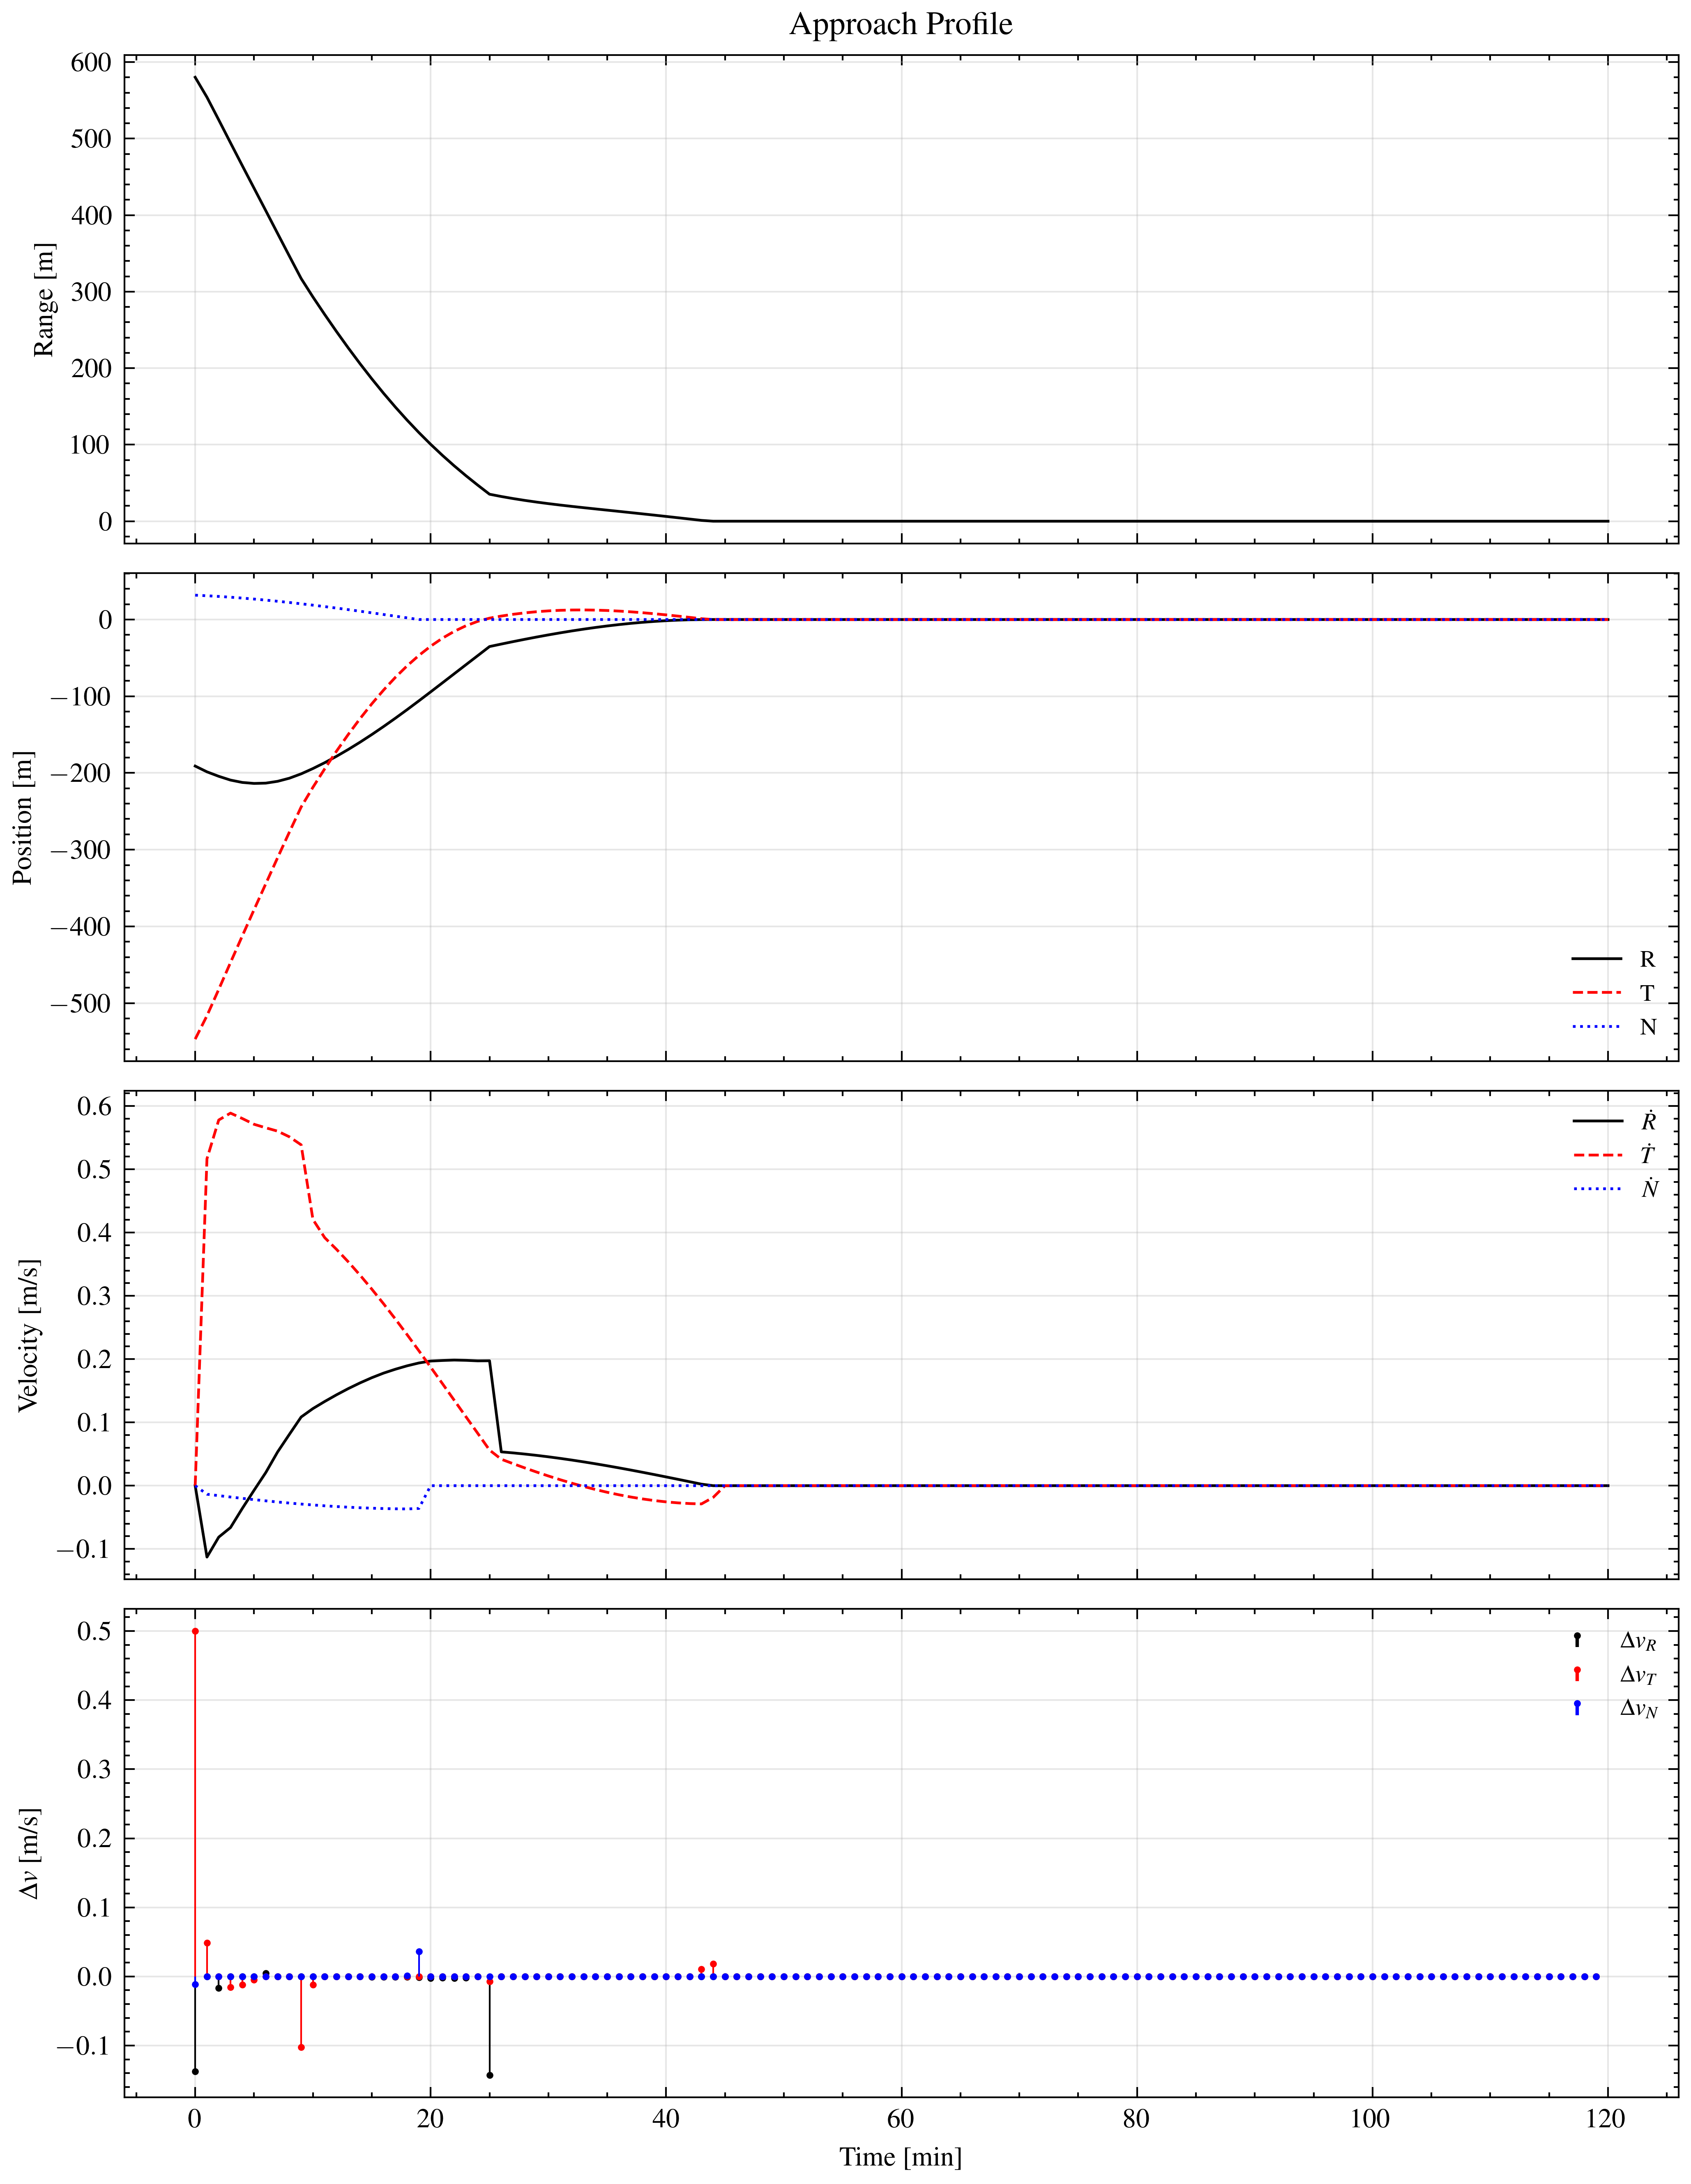

In [9]:
t_min = np.arange(N_STEPS + 1) * DT / 60.0
t_dv = np.arange(N_STEPS) * DT / 60.0

fig, axes = plt.subplots(4, 1, figsize=(7, 9), sharex=True)

# --- Range ---
rng = np.linalg.norm(rtn_history[:, :3], axis=1)
axes[0].plot(t_min, rng, linewidth=0.8)
axes[0].set_ylabel("Range [m]")
axes[0].set_title("Approach Profile")
axes[0].grid(True, alpha=0.3)

# --- RTN position ---
labels_pos = ["R", "T", "N"]
for i in range(3):
    axes[1].plot(t_min, rtn_history[:, i], linewidth=0.8, label=labels_pos[i])
axes[1].set_ylabel("Position [m]")
axes[1].legend(fontsize=7)
axes[1].grid(True, alpha=0.3)

# --- RTN velocity ---
labels_vel = [r"$\dot{R}$", r"$\dot{T}$", r"$\dot{N}$"]
for i in range(3):
    axes[2].plot(t_min, rtn_history[:, 3 + i], linewidth=0.8, label=labels_vel[i])
axes[2].set_ylabel("Velocity [m/s]")
axes[2].legend(fontsize=7)
axes[2].grid(True, alpha=0.3)

# --- Delta-v stems ---
colors = ["C0", "C1", "C2"]
labels_dv = [r"$\Delta v_R$", r"$\Delta v_T$", r"$\Delta v_N$"]
for i in range(3):
    markerline, stemlines, baseline = axes[3].stem(
        t_dv, dv_history[:, i], markerfmt=".", basefmt=" ", label=labels_dv[i]
    )
    plt.setp(stemlines, linewidth=0.5, color=colors[i])
    plt.setp(markerline, markersize=2, color=colors[i])
axes[3].set_ylabel(r"$\Delta v$ [m/s]")
axes[3].set_xlabel("Time [min]")
axes[3].legend(fontsize=7)
axes[3].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

In [10]:
# --- Summary statistics ---
initial_range = np.linalg.norm(rtn_history[0, :3])
final_range = np.linalg.norm(rtn_history[-1, :3])
total_dv_l1 = np.sum(np.abs(dv_history))
total_dv_l2 = np.sum(np.sqrt(np.sum(dv_history**2, axis=1)))
active_burns = np.sum(np.any(np.abs(dv_history) > 1e-6, axis=1))

print("=" * 45)
print("  MPC Rendezvous Summary")
print("=" * 45)
print(f"  Initial range:       {initial_range:10.2f} m")
print(f"  Final range:         {final_range:10.2f} m")
print(f"  Final velocity:      {np.linalg.norm(rtn_history[-1, 3:]):10.4f} m/s")
print(f"  Total delta-v (L1):  {total_dv_l1:10.4f} m/s")
print(f"  Total delta-v (L2):  {total_dv_l2:10.4f} m/s")
print(f"  Active burn steps:   {active_burns:10d} / {N_STEPS}")
print(f"  Sim duration:        {N_STEPS*DT/60:10.0f} min")
print("=" * 45)

  MPC Rendezvous Summary
  Initial range:           580.23 m
  Final range:               0.00 m
  Final velocity:          0.0000 m/s
  Total delta-v (L1):      1.0952 m/s
  Total delta-v (L2):      0.9561 m/s
  Active burn steps:           42 / 120
  Sim duration:               120 min
